In [1]:
import pandas as pd
import numpy as np
import binascii
from scipy.stats import pearsonr
file_path = './traces_AES.csv'

# Load the CSV file with low_memory set to False
df = pd.read_csv(file_path, header=None, low_memory=False)
df1=df.to_numpy()
print (df1)
keyByteToFind=11

[['Plaintext' 'Ciphertext' 'Traces' ... nan nan nan]
 ['0' '7df76b0c1ab899b33e42f047b91b546f' '366' ... 310.0 305.0 261.0]
 ['7df76b0c1ab899b33e42f047b91b546f' 'a9dcf5aa138056e259e7be57958e72d8'
  '389' ... 264.0 285.0 292.0]
 ...
 ['2fe99af02c983246ff228ced17239b24' '96acd213cd6ac463b3be6859d725f6c6'
  '367' ... 290.0 258.0 268.0]
 ['96acd213cd6ac463b3be6859d725f6c6' '80c87c1dc35a8b945f9e9f6d5f1db1d1'
  '372' ... 323.0 296.0 294.0]
 ['80c87c1dc35a8b945f9e9f6d5f1db1d1' 'e35457b42cc2c384f5b40dc80312cd71'
  '387' ... 278.0 285.0 283.0]]


In [2]:
# Extract columns
#plaintexts = df.iloc[:, 0].values
#ciphertexts = df.iloc[:, 1].values
traces = df.iloc[1:, 2:].values  # Power trace data

#traces=df1[1:, 2:2000]
traces

array([['366', 237.0, 206.0, ..., 310.0, 305.0, 261.0],
       ['389', 252.0, 208.0, ..., 264.0, 285.0, 292.0],
       ['376', 255.0, 213.0, ..., 301.0, 278.0, 276.0],
       ...,
       ['367', 296.0, 211.0, ..., 290.0, 258.0, 268.0],
       ['372', 300.0, 213.0, ..., 323.0, 296.0, 294.0],
       ['387', 294.0, 205.0, ..., 278.0, 285.0, 283.0]], dtype=object)

In [3]:
def normalize_plaintext(plaintext):
    # Normalize '0' to a full 16-byte (32-character) zero string
    if plaintext == '0':
        return '00000000000000000000000000000000'
    else:
        return plaintext
    


In [4]:
#Getting the plaintext part
#plaintexts=df1[:,0]
plaintexts = df.iloc[1:, 0].values
# Convert plaintexts to byte arrays
plaintexts_norm =  np.array([normalize_plaintext(pt) for pt in plaintexts],dtype=object)
plaintexts_norm

array(['00000000000000000000000000000000',
       '7df76b0c1ab899b33e42f047b91b546f',
       'a9dcf5aa138056e259e7be57958e72d8', ...,
       '2fe99af02c983246ff228ced17239b24',
       '96acd213cd6ac463b3be6859d725f6c6',
       '80c87c1dc35a8b945f9e9f6d5f1db1d1'], dtype=object)

In [5]:
#Getting Ciphertext part
#ciphertexts=df1[:,1]
ciphertexts = df.iloc[1:, 1].values
ciphertexts_norm= np.array([normalize_plaintext(pt) for pt in ciphertexts],dtype=object)
ciphertexts_norm

array(['7df76b0c1ab899b33e42f047b91b546f',
       'a9dcf5aa138056e259e7be57958e72d8',
       '626caecce6b25a25524cb32b7ec1374e', ...,
       '96acd213cd6ac463b3be6859d725f6c6',
       '80c87c1dc35a8b945f9e9f6d5f1db1d1',
       'e35457b42cc2c384f5b40dc80312cd71'], dtype=object)

In [6]:
InvSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)


In [7]:
#np.shape(ciphertexts)[0]
num_traces,num_points= np.shape(traces)
num_traces,num_points

(30000, 150)

In [8]:
cipher9=np.empty([num_traces,256])

In [9]:
#For Hamming weight
def number_of_ones(n):
    c = 0
    while n:
        c += n%2
        n /= 2
    return c

In [16]:
# Define necessary arrays
hypothetical_model = np.empty([num_traces, 256], dtype=np.float64)
corr_matrix = np.empty([256, num_points], dtype=np.float64)

def number_of_ones(x):
    return bin(x).count('1')
# Storing the dictionary in a variable
key_s_combination = {0: 0, 5: 1, 10: 2, 15: 3, 4: 4, 9: 5, 14: 6, 3: 7, 8: 8, 13: 9, 
           2: 10, 7: 11, 12: 12, 1: 13, 6: 14, 11: 15}
# Looping through the dictionary and reading the values one by one
for svalue, key in key_s_combination.items():
    #print(f"Key: {key}, Value: {value}")
    # Perform CPA computations
        if(key==keyByteToFind):
            for j in range(num_traces):
                for k in range(256):
                    try:
                        # Ensure we're working with valid hexadecimal strings
                        #c11 = ciphertexts_norm[j][22:24] #for C11
                        c11 = ciphertexts_norm[j][key*2:(key*2)+2] #for C11
                        #c11 = ciphertexts_norm[j][18:20]
                        xorc11k11 = int(c11, 16) ^ k

                        cipher9 = InvSbox[xorc11k11]
                        
                        #x1 = ciphertexts_norm[j][14:16] # need to target C7
                        x1 = ciphertexts_norm[j][svalue*2:(svalue*2)+2] #for C11
                        #x1 = ciphertexts_norm[j][10:12]
                        x2 = int(x1, 16)
                        xor1 = x2 ^ int(cipher9)
                        hamming_dist = number_of_ones(xor1)
                        hypothetical_model[j, k] = hamming_dist
                    except ValueError as e:
                        print(f"Error processing ciphertext '{ciphertexts_norm[j]}': {e}")
                        continue

            # Convert traces to DataFrame
            tr = pd.DataFrame(traces, dtype=np.float64)
            hy = pd.DataFrame(hypothetical_model, dtype=np.float64)

            # Calculate correlation matrix
            for i in range(256):
                for j in range(num_points):
                    c1 = hy.iloc[:, i].values
                    c2 = tr.iloc[:, j].values
                    try:
                        corr, _ = pearsonr(c1, c2)
                        corr_matrix[i, j] = abs(corr)
                    except ValueError as e:
                        print(f"Error calculating correlation for byte {i}, point {j}: {e}")
                        corr_matrix[i, j] = 0  # Default value if error occurs

            # Find the best correlation
            from numpy import unravel_index
            x, y = unravel_index(corr_matrix.argmax(), corr_matrix.shape)

            #print(f"Best key byte guess position: {x}")
            #print(f"Best trace point position: {y}")
            print(f"The correct {key} key byte is",x,", hex value =",hex(x))

The correct 0 key byte is 208 , hex value = 0xd0
The correct 1 key byte is 20 , hex value = 0x14


KeyboardInterrupt: 

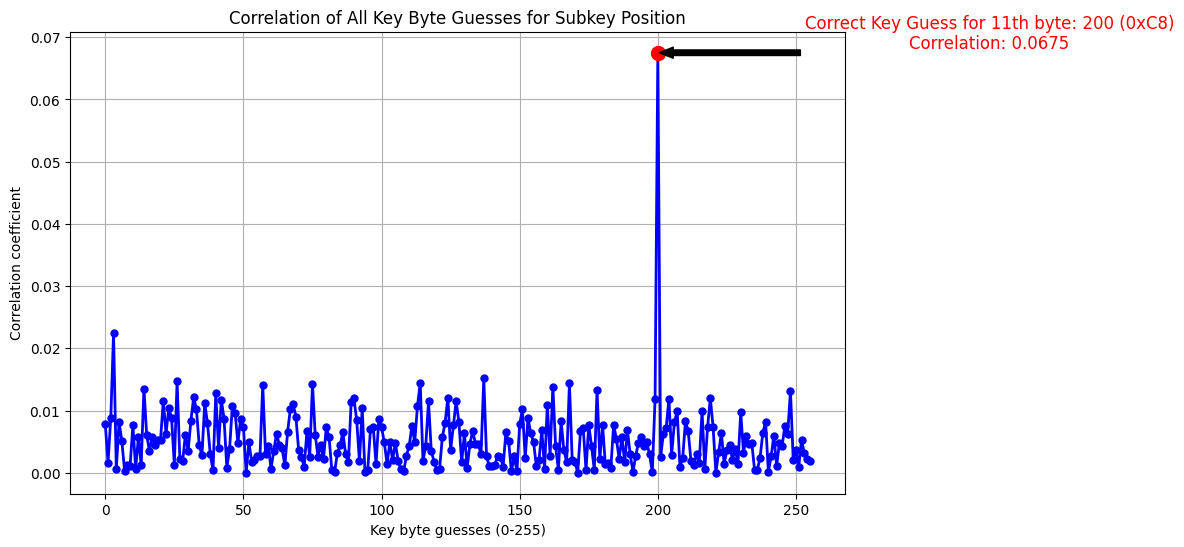

In [12]:
import matplotlib.pyplot as plt

# Create a new plot
plt.figure(figsize=(10, 6))

# Plot the correlation values for each subkey guess (0-255)
plt.plot(range(256), corr_matrix[:, y], 'bo-', linewidth=2, markersize=5)

# Highlight the correct key byte guess
plt.plot(x, corr_matrix[x, y], 'ro', markersize=10)  # Highlight the correct guess in red

# Add labels and title
plt.ylabel('Correlation coefficient')
plt.xlabel('Key byte guesses (0-255)')
plt.title('Correlation of All Key Byte Guesses for Subkey Position')

# Annotate the correct key guess with its value and correlation coefficient
annotation_text = f'Correct Key Guess for 11th byte: {x} (0x{x:02X})\nCorrelation: {corr_matrix[x, y]:.4f}'
plt.annotate(annotation_text, xy=(x, corr_matrix[x, y]), xytext=(x+120, corr_matrix[x, y]),
             arrowprops=dict(facecolor='black', shrink=0.01, headwidth=8, headlength=10),  # Shortened arrow
             fontsize=12, color='red', ha='center', va='bottom')

# Display the plot
plt.grid(True)
plt.show()


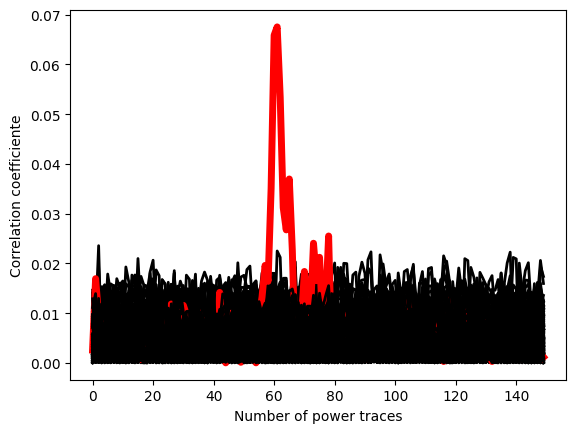

In [13]:
#print corr_matrix
import matplotlib.pyplot as plt
for i in range(256):
    if (i==x):
        plt.plot(range(num_points),corr_matrix[i,:], 'r',linewidth=5)
    else:
        plt.plot(range(num_points),corr_matrix[i,:], 'k', linewidth=2)
plt.ylabel('Correlation coefficiente')
plt.xlabel('Number of power traces')
plt.show()
